In [1]:
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.utils import common
from keras.layers import Dense
from environment_functions import *

In [2]:
# Settings
max_action = 100
min_action = 20
action_price_step = 2
num_actions = (max_action-min_action) / action_price_step
num_features = 33

discount = 1.0
comp_sellout_price = 100
early_termination_penalty = 10
price_diff_penalty = 0.05
loadfactor_diff_penalty = 0.5
stock_remainder_penalty = 40

hidden_units_layer1 = 20
hidden_units_layer2 = 40
learning_rate = 1e-3
beta_1 = 0.9
beta_2 = 0.999
target_update_period = 2000

policy = 'boltzmann_temperature'
exponential_decay_rate = 1.0
boltzmann_temperature_start = 100.0
boltzmann_temperature_end = 1.0
epsilon_greedy_start = 1.0
epsilon_greedy_end = 0.01
decay_steps = 12 * 1000 * 100

replay_buffer_batch_size = 1
replay_buffer_max_size = 10000
sample_batch_size = 64
num_steps = 2
num_parallel_calls = 4

seed = 123
tf.random.set_seed(seed)

In [3]:
# Environments
dpc_game = DynamicPricingCompetition()
simulator = ExternalSimulator()
environment = AirlineEnvironment(dpc_game, simulator, num_features, num_actions, discount, min_action,
                                 action_price_step, comp_sellout_price, early_termination_penalty, price_diff_penalty,
                                 loadfactor_diff_penalty, stock_remainder_penalty)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [4]:
# Set up the agent and the network for the agent
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=hidden_units_layer1, input_shape=(num_features,), activation='relu',
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=hidden_units_layer2, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)

In [5]:
train_step_counter = tf.Variable(0)

if policy == 'boltzmann_temperature':
    if exponential_decay_rate == 1:
        epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=boltzmann_temperature_start,
                        decay_steps=decay_steps,
                        end_learning_rate=boltzmann_temperature_end)
    else:
        epsilon_fn = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=boltzmann_temperature_start,
            decay_steps=decay_steps,
            decay_rate=exponential_decay_rate,
        )

    agent = dqn_agent.DqnAgent(
        time_step_spec=train_env.time_step_spec(),
        action_spec=train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=discount,
        boltzmann_temperature=lambda: epsilon_fn(train_step_counter),
        epsilon_greedy=None,
        train_step_counter=train_step_counter
    )
elif policy == 'epsilon_greedy':
    if exponential_decay_rate == 1:
        epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                        initial_learning_rate=epsilon_greedy_start,
                        decay_steps=decay_steps,
                        end_learning_rate=epsilon_greedy_end)
    else:
        epsilon_fn = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=epsilon_greedy_start,
            decay_steps=decay_steps,
            decay_rate=exponential_decay_rate,
        )

    agent = dqn_agent.DqnAgent(
        time_step_spec=train_env.time_step_spec(),
        action_spec=train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=discount,
        epsilon_greedy=lambda: epsilon_fn(train_step_counter),
        train_step_counter=train_step_counter
    )

agent.initialize()

In [6]:
# replay buffer and driver for training
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=replay_buffer_batch_size,
    max_length=replay_buffer_max_size
)

In [7]:
# Make reusing a model possible
train_checkpointer = common.Checkpointer(
    ckpt_dir='.',
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter
)

In [8]:
# Setup training
dataset = replay_buffer.as_dataset(
    sample_batch_size=sample_batch_size,
    num_steps=num_steps,
    num_parallel_calls=num_parallel_calls,
).prefetch(num_parallel_calls)

agent.train = common.function(agent.train)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [9]:
# Load competition data to rerun simulations
comp_data = pd.read_csv(f'duopoly_competition_details_20211225.csv', sep=',')

In [10]:
comp_data.head()

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors
0,49GwA4,1,1,EagerToad,49.5,50.0,1,True,0.0,NaN
1,49GwA4,1,2,EagerToad,49.8,48.0,1,True,0.0,NaN
2,49GwA4,1,3,EagerToad,50.2,46.0,0,True,0.0,NaN
3,49GwA4,1,4,EagerToad,50.8,44.0,0,True,0.0,NaN
4,49GwA4,1,5,EagerToad,51.2,42.0,0,True,0.0,NaN


In [11]:
comp_data.shape

(500000, 10)

In [12]:
comp_data.head(100)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors
0,49GwA4,1,1,EagerToad,49.5,50.0,1,True,0.0,NaN
1,49GwA4,1,2,EagerToad,49.8,48.0,1,True,0.0,NaN
2,49GwA4,1,3,EagerToad,50.2,46.0,0,True,0.0,NaN
3,49GwA4,1,4,EagerToad,50.8,44.0,0,True,0.0,NaN
4,49GwA4,1,5,EagerToad,51.2,42.0,0,True,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...
95,49GwA4,1,96,EagerToad,44.6,52.0,2,True,0.0,NaN
96,49GwA4,1,97,EagerToad,44.1,54.0,1,True,0.0,NaN
97,49GwA4,1,98,EagerToad,43.6,56.0,0,True,0.0,NaN
98,49GwA4,1,99,EagerToad,43.1,54.0,0,True,0.0,NaN


In [63]:
comp_matches = comp_data[['competition_id', 'selling_season']].drop_duplicates().reset_index(drop=True)
len(comp_matches)

5000

In [62]:
from helper_functions import plot_price_and_loadfactor

In [64]:
comp_matches.sample(5)

,competition_id,selling_season
3199,3ZqCaS,100
1480,4LJcet,81
4978,36ey93,79
2604,zaWyyy,5
1948,hFN9VQ,49


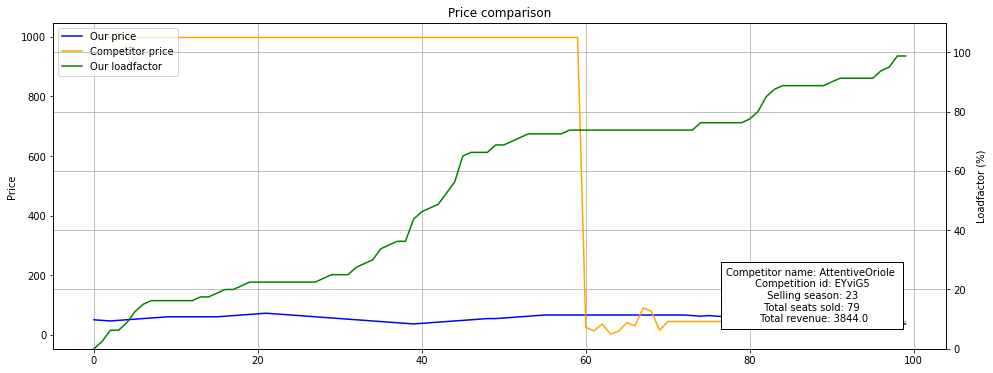

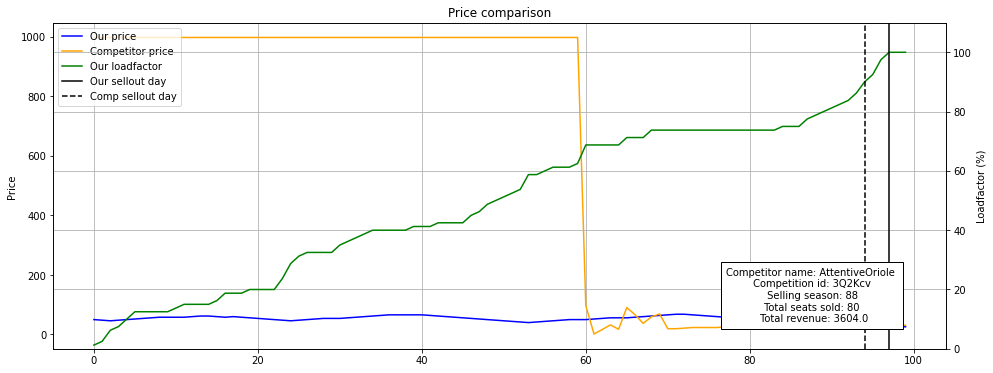

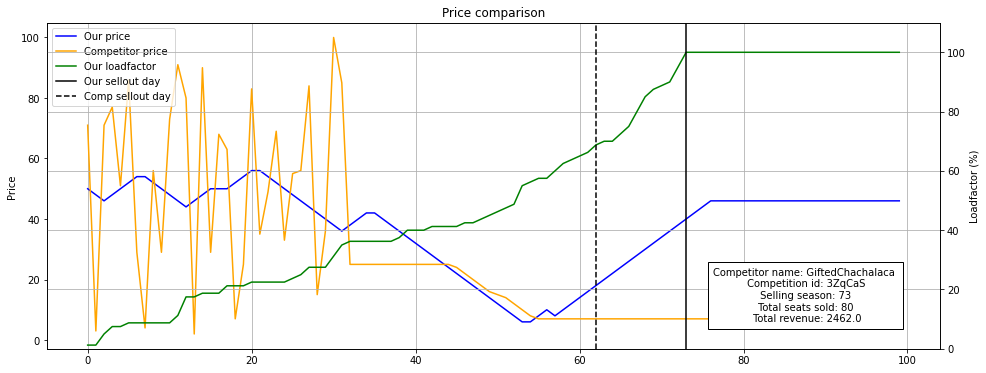

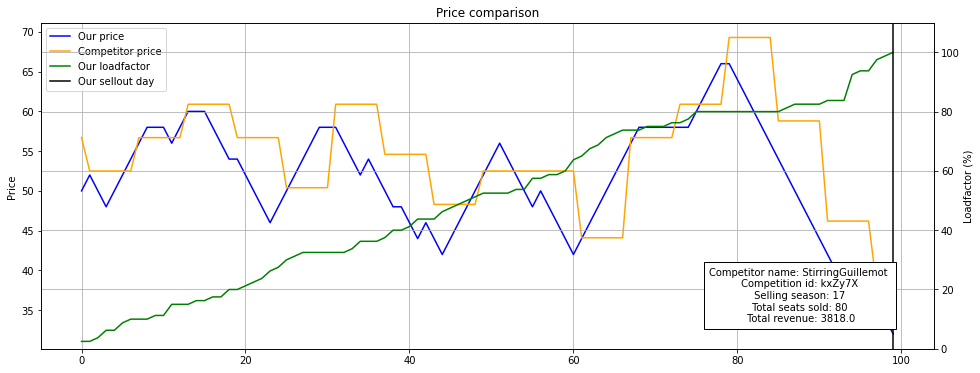

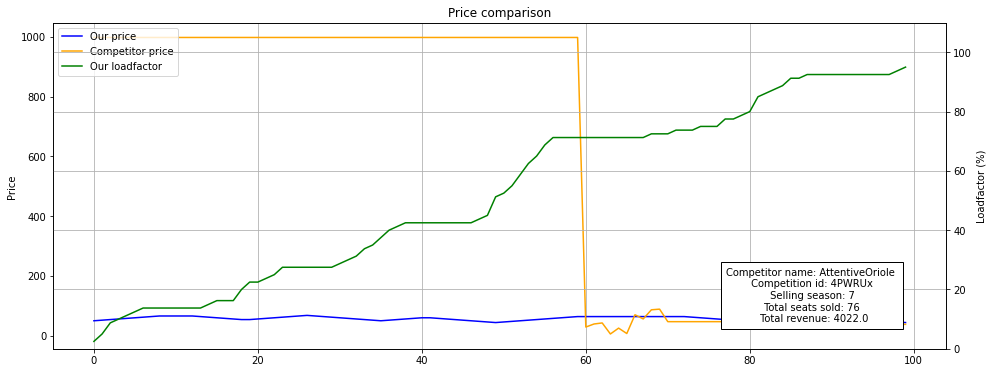

In [65]:
sampled_matches = comp_matches.sample(5).reset_index(drop=True)

for i in range(5):
    selling_season = sampled_matches.loc[i, 'selling_season']
    competition_id = sampled_matches.loc[i, 'competition_id']

    plot_price_and_loadfactor(comp_data, competition_id, selling_season, None)

In [17]:
for i in range(len(comp_matches)):
    
    if i % 100 == 0:
        print(f'Start training for comp match: {i}')
    
    example_comp_data = comp_data[
        (comp_data['competition_id'] == comp_matches.loc[i, 'competition_id']) & 
        (comp_data['selling_season'] == comp_matches.loc[i, 'selling_season'])
    ].reset_index(drop=True)
    example_comp_data['loadfactor'] = example_comp_data['demand'].cumsum() / 80 * 100

    i=0

    iterator = iter(dataset)
    last_comp_price = 50

    dpc_game.reset()
    simulator.reset_environment()
    time_step = train_env.reset()

    first_price = example_comp_data.loc[0, 'price']

    action_step = PolicyStep(
        action=(tf.constant([np.max([0, int((first_price-20)/2)])])), 
        state=(), info=())
    last_price = min_action + int(action_step.action) * action_price_step

    prev_step = time_step
    prev_action_step = action_step 

    while True:
        last_comp_price = example_comp_data.loc[i, 'price_competitor']
        last_demand = example_comp_data.loc[i, 'demand']
        competitor_has_capacity = example_comp_data.loc[i, 'competitor_has_capacity']

        simulator.update(last_price, last_comp_price, last_demand, competitor_has_capacity)
        time_step = train_env.step(action_step)

        # Add trajectory and adding to replay buffer + training
        traj = Trajectory(
            prev_step.step_type,
            prev_step.observation,
            prev_action_step.action,
            prev_action_step.info,
            time_step.step_type,
            time_step.reward,
            time_step.discount
        )
        replay_buffer.add_batch(traj)

        if replay_buffer.num_frames() > 5000:
            trajectories, _ = next(iterator)
            _ = agent.train(experience=trajectories)

        if int(time_step.step_type) == 2:
            break
        else:
            i+=1
            action_step = PolicyStep(
                action=(tf.constant([np.max([0, int((example_comp_data.loc[i, 'price']-20)/2)])])), 
                state=(), info=())
            last_price = min_action + int(action_step.action) * action_price_step

            # Save step and action for the next round
            prev_step = time_step
            prev_action_step = action_step

train_checkpointer.save(train_step_counter)
print('Finished training')

Start training for comp match: 0
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Start training for comp match: 100
Start training for comp match: 200
Start training for comp match: 300
Start training for comp match: 400
Start training for comp match: 500
Start training for comp match: 600
Start training for comp match: 700
Start training for comp match: 800
Start training for comp match: 900
Start training for comp match: 1000
Start training for comp match: 1100
Start training for comp match: 1200
Start training for comp match: 1300
Start training for comp match: 1400
Start training for comp match: 1500
Start training for comp match: 1600
Start training for comp match: 1700
Start training for comp match: 1800
Start training for comp match: 1900
Start training for comp match: 2000
Start training for comp match: 2100
Start training for comp match: 2200
Start training for comp match: 2300
Start training for comp match: 2400
Start training for comp match: 2500
Start training for comp match: 2600
Start training for comp match: 2700
Start training for comp match: 2800
S

In [18]:
replay_buffer.num_frames()

<tf.Tensor: shape=(), dtype=int64, numpy=10000>

In [ ]:
# check how agent would interact now with env..


In [21]:
int(prev_action_step.action)

16

In [ ]:
for i in range(1):
    
    if i % 100 == 0:
        print(f'Start training for comp match: {i}')
    
    example_comp_data = comp_data[
        (comp_data['competition_id'] == comp_matches.loc[i, 'competition_id']) & 
        (comp_data['selling_season'] == comp_matches.loc[i, 'selling_season'])
    ].reset_index(drop=True)
    example_comp_data['loadfactor'] = example_comp_data['demand'].cumsum() / 80 * 100

    i=0

    iterator = iter(dataset)
    last_comp_price = 50

    dpc_game.reset()
    simulator.reset_environment()
    time_step = train_env.reset()

    first_price = example_comp_data.loc[0, 'price']

    action_step = PolicyStep(
        action=(tf.constant([np.max([0, int((first_price-20)/2)])])), 
        state=(), info=())
    last_price = min_action + int(action_step.action) * action_price_step

    prev_step = time_step
    prev_action_step = action_step 

    while True:
        last_comp_price = example_comp_data.loc[i, 'price_competitor']
        last_demand = example_comp_data.loc[i, 'demand']
        competitor_has_capacity = example_comp_data.loc[i, 'competitor_has_capacity']

        simulator.update(last_price, last_comp_price, last_demand, competitor_has_capacity)
        time_step = train_env.step(action_step)

        # Add trajectory and adding to replay buffer + training
        traj = Trajectory(
            prev_step.step_type,
            prev_step.observation,
            prev_action_step.action,
            prev_action_step.info,
            time_step.step_type,
            time_step.reward,
            time_step.discount
        )
        replay_buffer.add_batch(traj)

        if replay_buffer.num_frames() > 5000:
            trajectories, _ = next(iterator)
            _ = agent.train(experience=trajectories)

        if int(time_step.step_type) == 2:
            break
        else:
            i+=1
            action_step = PolicyStep(
                action=(tf.constant([np.max([0, int((example_comp_data.loc[i, 'price']-20)/2)])])), 
                state=(), info=())
            last_price = min_action + int(action_step.action) * action_price_step

            # Save step and action for the next round
            prev_step = time_step
            prev_action_step = action_step

train_checkpointer.save(train_step_counter)
print('Finished training')

In [22]:
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 33), dtype=int32, numpy=
array([[96, 80,  1, 56, 56, 56, 56, 56, 56, 46, 46, 46, 46, 52, 52, 54,
        54, 54, 54, 54, 52, 50, 48,  4,  1,  0,  0,  1,  0,  0,  0,  1,
         2]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([168.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>})

In [39]:
ts.TimeStep(step_type=tf.constant([1]), reward=tf.constant([52.]), discount=tf.constant([1.0]),
            observation=tf.constant([np.array([95, 76,  1, 56, 56, 56, 56, 56, 46, 46, 46, 46, 46, 52, 54, 54,
            54, 54, 54, 52, 50, 48, 46,  1,  0,  0,  1,  0,  0,  0,  1,  2, 1])]))

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 33), dtype=int32, numpy=
array([[95, 76,  1, 56, 56, 56, 56, 56, 46, 46, 46, 46, 46, 52, 54, 54,
        54, 54, 54, 52, 50, 48, 46,  1,  0,  0,  1,  0,  0,  0,  1,  2,
         1]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([52.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})

In [30]:
type(prev_action_step)

tf_agents.trajectories.policy_step.PolicyStep

In [23]:
dpc_game.selling_period

96

In [24]:
time_step = train_env.step(action_step)

In [25]:
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 33), dtype=int32, numpy=
array([[ 1,  0,  1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})

In [26]:
simulator._selling_period

1

In [59]:
discount = np.array(time_step[0])
observation = np.array(time_step[1])
reward = np.array(time_step[2])
step_type = np.array(time_step[3])

discount, observation, reward, step_type

(array([0]),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([[ 1,  0,  1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1]]))

In [61]:
ts.TimeStep(tf.constant(discount), tf.constant(observation), tf.constant(reward), tf.constant(step_type))

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 33), dtype=int32, numpy=
array([[ 1,  0,  1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})